In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

## Dataset

In [2]:
df = pd.read_csv('day.csv')

df = df.drop(columns=['casual','registered','instant','dteday','mnth','yr'])

#df = pd.get_dummies(df, columns=['season','weathersit','weekday'])
target = 'cnt'
df.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [3]:
# Función de calibración
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'blue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'red')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Modelo KNN

### Sin estandarizar

In [4]:
# Sin estandarizar
X = df.copy()
X = X.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = KNeighborsRegressor().fit(X_train, y_train)
predicciones_no_est = model.predict(X_test)

r2_score(y_test, predicciones_no_est)

0.39373967700997947

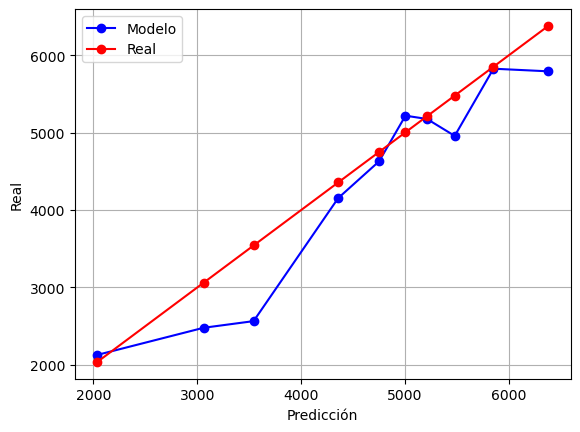

In [5]:
calibracion(predicciones_no_est, y_test, 10)

### Estandariando

In [6]:
# Estandarizando
X = df.copy()
X = X.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

model = KNeighborsRegressor().fit(X_train_scaled, y_train)
predicciones_est = model.predict(X_test_scaled)

r2_score(y_test, predicciones_est)

0.5446941650293745

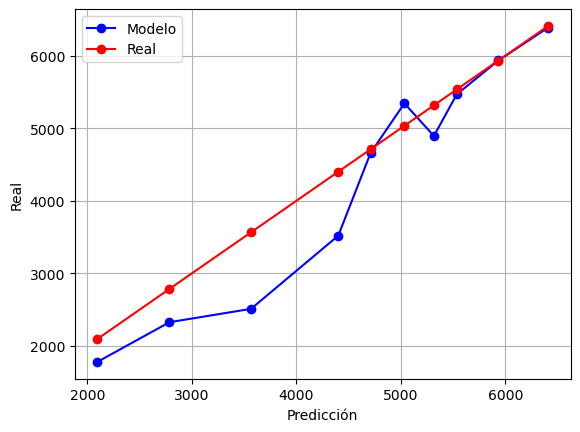

In [7]:
calibracion(predicciones_est, y_test, 10)

## Buscando el óptimo

In [8]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)
    r2.append(r2_score(y_test, predicciones))
    nn.append(i)
    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_train, predicciones_train))

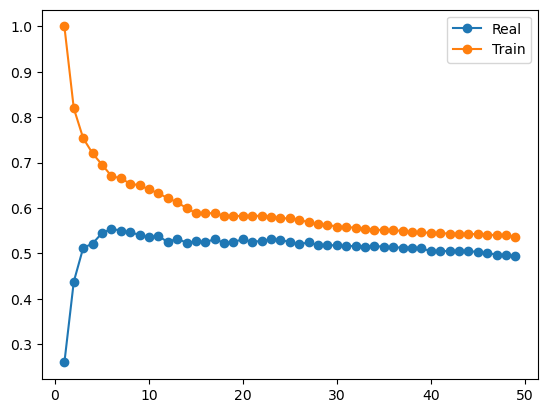

In [9]:
## Grafica los resultados
resultados = pd.DataFrame({
    'nn': nn,
    'r2': r2,
    'r2_train': r2_train
})

plt.plot(resultados.nn, resultados.r2, marker='o', label='Real')
plt.plot(resultados.nn, resultados.r2_train, marker='o', label='Train')
plt.legend();

In [10]:
opt_neighbors = resultados[resultados.r2 == max(resultados.r2)]

In [11]:
opt_neighbors

,nn,r2,r2_train
5,6,0.553907,0.670864
